# DeepXDE教程3：PDE方程组求解

## 🎯 教程目标
本教程将介绍如何使用DeepXDE求解偏微分方程组（PDE Systems）。你将学会：
- 处理多变量耦合PDE系统
- 设置多个边界条件和初始条件
- 构建多输出神经网络
- 分析耦合系统的解耦合特性
- 可视化多变量解的演化过程

## 📚 背景知识

### 反应扩散方程组
我们将求解经典的反应扩散方程组，这是描述化学反应和物质扩散耦合过程的典型模型：

**方程组**：
$$\begin{cases}
\frac{\partial u}{\partial t} = D_u \frac{\partial^2 u}{\partial x^2} + f(u,v) \\
\frac{\partial v}{\partial t} = D_v \frac{\partial^2 v}{\partial x^2} + g(u,v)
\end{cases}$$

其中，我们选择简化的线性反应项：
$$\begin{cases}
f(u,v) = a \cdot u - b \cdot v \\
g(u,v) = c \cdot u + d \cdot v
\end{cases}$$

**定义域**：$x \in [0, 1], t \in [0, 1]$

**参数设置**：
- $D_u = 0.01$ (u的扩散系数)
- $D_v = 0.02$ (v的扩散系数)  
- $a = 1, b = 1, c = 1, d = -1$ (反应系数)

**边界条件**：
$$u(0,t) = u(1,t) = 0, \quad v(0,t) = v(1,t) = 0$$

**初始条件**：
$$\begin{cases}
u(x,0) = \sin(\pi x) \\
v(x,0) = 0.5 \sin(2\pi x)
\end{cases}$$

### 与单个PDE的区别
- **多变量**: 同时求解u(x,t)和v(x,t)
- **耦合性**: u和v通过反应项相互影响
- **网络输出**: 神经网络需要输出2个变量
- **损失函数**: 包含两个PDE的残差
- **复杂性**: 系统行为比单个方程更丰富

## 1. 环境准备

In [11]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import time

# 检查DeepXDE版本和后端
print(f"DeepXDE版本: {dde.__version__}")
print(f"当前后端: {dde.backend.backend_name}")

# 设置matplotlib参数
plt.rcParams['font.sans-serif'] = ['Arial', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = [10, 6]

# 设置随机种子确保结果可重现
np.random.seed(42)
dde.config.set_random_seed(42)

print("✅ 环境准备完成")

DeepXDE版本: 1.14.0
当前后端: pytorch
✅ 环境准备完成


## 2. 定义方程组参数

In [12]:
# 定义物理参数
Du = 0.01  # u的扩散系数
Dv = 0.02  # v的扩散系数

# 反应系数
a, b, c, d = 1.0, 1.0, 1.0, -1.0

print("📝 方程组参数：")
print(f"扩散系数: Du = {Du}, Dv = {Dv}")
print(f"反应系数: a = {a}, b = {b}, c = {c}, d = {d}")
print()
print("🧮 完整方程组：")
print(f"∂u/∂t = {Du} ∂²u/∂x² + {a}u - {b}v")
print(f"∂v/∂t = {Dv} ∂²v/∂x² + {c}u + {d}v")
print("✅ 参数设置完成")

📝 方程组参数：
扩散系数: Du = 0.01, Dv = 0.02
反应系数: a = 1.0, b = 1.0, c = 1.0, d = -1.0

🧮 完整方程组：
∂u/∂t = 0.01 ∂²u/∂x² + 1.0u - 1.0v
∂v/∂t = 0.02 ∂²v/∂x² + 1.0u + -1.0v
✅ 参数设置完成


## 3. 定义PDE方程组

In [13]:
def pde_system(x, y):
    """
    定义反应扩散方程组
    
    Args:
        x: 输入坐标 [x, t] (N, 2)
        y: 神经网络输出 [u, v] (N, 2) - 注意：现在是2个输出
        
    Returns:
        PDE系统残差 [residual_u, residual_v] (N, 2)
    """
    # 提取u和v（神经网络的两个输出）
    u = y[:, 0:1]  # 第一个输出：u(x,t)
    v = y[:, 1:2]  # 第二个输出：v(x,t)
    
    # 计算u的导数
    du_t = dde.grad.jacobian(u, x, i=0, j=1)   # ∂u/∂t
    du_xx = dde.grad.hessian(u, x, i=0, j=0)   # ∂²u/∂x²
    
    # 计算v的导数
    dv_t = dde.grad.jacobian(v, x, i=0, j=1)   # ∂v/∂t
    dv_xx = dde.grad.hessian(v, x, i=0, j=0)   # ∂²v/∂x²
    
    # 定义反应项
    reaction_u = a * u - b * v  # f(u,v) = au - bv
    reaction_v = c * u + d * v  # g(u,v) = cu + dv
    
    # PDE方程组残差
    residual_u = du_t - Du * du_xx - reaction_u  # ∂u/∂t - Du∂²u/∂x² - f(u,v) = 0
    residual_v = dv_t - Dv * dv_xx - reaction_v  # ∂v/∂t - Dv∂²v/∂x² - g(u,v) = 0
    
    # 返回两个方程的残差
    return [residual_u, residual_v]

print("✅ PDE方程组定义完成")
print("💡 注意：")
print("   - 神经网络输出2个变量：u(x,t) 和 v(x,t)")
print("   - 返回2个PDE残差：residual_u 和 residual_v")
print("   - 反应项实现了u和v之间的耦合")

✅ PDE方程组定义完成
💡 注意：
   - 神经网络输出2个变量：u(x,t) 和 v(x,t)
   - 返回2个PDE残差：residual_u 和 residual_v
   - 反应项实现了u和v之间的耦合


## 4. 定义时空域

In [14]:
# 定义空间域和时间域
geom = dde.geometry.Interval(0, 1)           # 空间域 [0, 1]
timedomain = dde.geometry.TimeDomain(0, 1)   # 时间域 [0, 1]
geomtime = dde.geometry.GeometryXTime(geom, timedomain)  # 时空域

print("✅ 时空域定义完成")
print(f"空间域: [0, 1]")
print(f"时间域: [0, 1]")
print(f"时空域类型: {type(geomtime)}")

✅ 时空域定义完成
空间域: [0, 1]
时间域: [0, 1]
时空域类型: <class 'deepxde.geometry.timedomain.GeometryXTime'>


## 5. 定义边界条件和初始条件

In [15]:
# 边界条件函数
def boundary(x, on_boundary):
    """定义边界位置"""
    return on_boundary

# 初始条件函数
def initial_condition_u(x):
    """u的初始条件：u(x,0) = sin(πx)"""
    return np.sin(np.pi * x[:, 0:1])

def initial_condition_v(x):
    """v的初始条件：v(x,0) = 0.5*sin(2πx)"""
    return 0.5 * np.sin(2 * np.pi * x[:, 0:1])

# 创建边界条件（u和v在边界上都为0）
bc_u = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary, component=0)  # u的边界条件
bc_v = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary, component=1)  # v的边界条件

# 创建初始条件
ic_u = dde.icbc.IC(geomtime, initial_condition_u, lambda _, on_initial: on_initial, component=0)  # u的初始条件
ic_v = dde.icbc.IC(geomtime, initial_condition_v, lambda _, on_initial: on_initial, component=1)  # v的初始条件

print("✅ 边界条件和初始条件定义完成")
print("💡 关键点：")
print("   - component=0 表示第一个输出变量 u")
print("   - component=1 表示第二个输出变量 v")
print("   - 每个变量都需要独立的边界条件和初始条件")

✅ 边界条件和初始条件定义完成
💡 关键点：
   - component=0 表示第一个输出变量 u
   - component=1 表示第二个输出变量 v
   - 每个变量都需要独立的边界条件和初始条件


## 6. 可视化初始条件

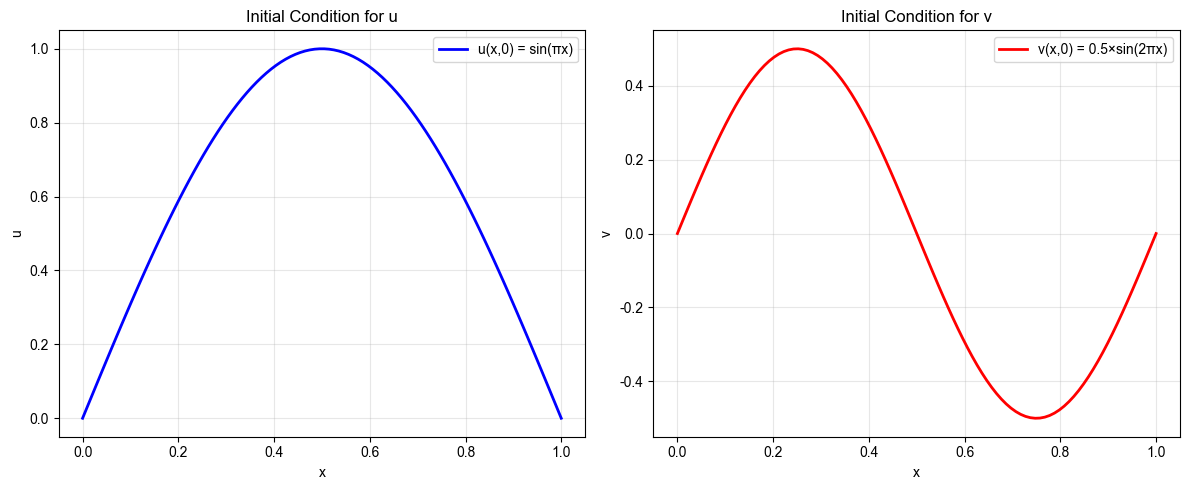

初始条件 u: 最大值 = 0.9999, 最小值 = 0.0000
初始条件 v: 最大值 = 0.4999, 最小值 = -0.4999


In [16]:
# 可视化初始条件
x_init = np.linspace(0, 1, 100).reshape(-1, 1)
x_init_with_time = np.column_stack([x_init.flatten(), np.zeros_like(x_init.flatten())])

# 计算初始条件
u_init = initial_condition_u(x_init_with_time)
v_init = initial_condition_v(x_init_with_time)

# 绘制初始条件
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_init.flatten(), u_init.flatten(), 'b-', linewidth=2, label='u(x,0) = sin(πx)')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Initial Condition for u')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_init.flatten(), v_init.flatten(), 'r-', linewidth=2, label='v(x,0) = 0.5×sin(2πx)')
plt.xlabel('x')
plt.ylabel('v')
plt.title('Initial Condition for v')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"初始条件 u: 最大值 = {np.max(u_init):.4f}, 最小值 = {np.min(u_init):.4f}")
print(f"初始条件 v: 最大值 = {np.max(v_init):.4f}, 最小值 = {np.min(v_init):.4f}")

## 7. 创建PDE数据

In [17]:
# 创建PDE系统数据
data = dde.data.TimePDE(
    geomtime,
    pde_system,
    [bc_u, bc_v, ic_u, ic_v],  # 包含所有边界条件和初始条件
    num_domain=2000,    # 域内采样点数
    num_boundary=40,    # 边界采样点数
    num_initial=40,     # 初始时刻采样点数
    num_test=500        # 测试点数
)

print("✅ PDE系统数据创建完成")
print(f"域内点数: {data.num_domain}")
print(f"边界点数: {data.num_boundary}")
print(f"初始点数: {data.num_initial}")
print(f"测试点数: {data.num_test}")
print()
print("💡 注意：方程组需要更多采样点以保证收敛")

✅ PDE系统数据创建完成
域内点数: 2000
边界点数: 40
初始点数: 40
测试点数: 500

💡 注意：方程组需要更多采样点以保证收敛


## 8. 构建神经网络

In [18]:
# 构建多输出神经网络
layer_size = [2] + [50] * 4 + [2]  # 输入2维(x,t)，输出2维(u,v)
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

print("✅ 神经网络构建完成")
print(f"网络结构: {layer_size}")
print(f"输入维度: 2 (x, t)")
print(f"输出维度: 2 (u, v)")
print(f"激活函数: {activation}")
print(f"初始化方法: {initializer}")

# 估算参数数量
total_params = (2*50 + 50) + 3*(50*50 + 50) + (50*2 + 2)
print(f"参数数量: ~{total_params:,}")
print()
print("💡 关键：")
print("   - 输出层有2个神经元，分别对应u和v")
print("   - 网络自动学习u和v之间的耦合关系")

✅ 神经网络构建完成
网络结构: [2, 50, 50, 50, 50, 2]
输入维度: 2 (x, t)
输出维度: 2 (u, v)
激活函数: tanh
初始化方法: Glorot uniform
参数数量: ~7,902

💡 关键：
   - 输出层有2个神经元，分别对应u和v
   - 网络自动学习u和v之间的耦合关系


## 9. 训练模型

In [ ]:
# 创建和编译模型
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

print("🚀 开始训练反应扩散方程组模型...")
print("⚠️  注意：方程组训练时间较长，请耐心等待...")

# 开始计时
start_time = time.time()

# 训练模型
losshistory, train_state = model.train(iterations=10000)

# 结束计时
train_time = time.time() - start_time

print(f"✅ 训练完成！用时: {train_time:.1f}秒")

# 获取最终损失 - 修复这里的错误
try:
    if hasattr(train_state.loss_train, '__len__') and len(train_state.loss_train) > 0:
        final_loss_train = float(train_state.loss_train[-1])
    else:
        final_loss_train = float(train_state.loss_train)
    
    if hasattr(train_state.loss_test, '__len__') and len(train_state.loss_test) > 0:
        final_loss_test = float(train_state.loss_test[-1])
    else:
        final_loss_test = float(train_state.loss_test)
    
    print(f"最终训练损失: {final_loss_train:.6f}")
    print(f"最终测试损失: {final_loss_test:.6f}")
except Exception as e:
    print(f"⚠️ 损失值访问出错: {e}")
    print("💡 训练已完成，可以继续下一步")

Compiling model...
'compile' took 0.000192 s

🚀 开始训练反应扩散方程组模型...
⚠️  注意：方程组训练时间较长，请耐心等待...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.00e-01, 1.95e-01, 1.33e-01, 7.81e-03, 2.03e-01, 1.26e-01]    [3.87e-01, 1.86e-01, 1.33e-01, 7.81e-03, 2.03e-01, 1.26e-01]    []  
🚀 开始训练反应扩散方程组模型...
⚠️  注意：方程组训练时间较长，请耐心等待...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.00e-01, 1.95e-01, 1.33e-01, 7.81e-03, 2.03e-01, 1.26e-01]    [3.87e-01, 1.86e-01, 1.33e-01, 7.81e-03, 2.03e-01, 1.26e-01]    []  
1000      [3.32e-04, 3.20e-04, 1.26e-04, 2.43e-04, 1.09e-04, 6.23e-05]    [2.24e-04, 2.27e-04, 1.26e-04, 2.43e-04, 1.09e-04, 6.23e-05]    []  
1000      [3.32e-04, 3.20e-04, 1.26e-04, 2.43e-04, 1.09e-04, 6.23e-05]    [2.24e-04, 2.27e-04, 1.

## 10. 可视化训练历史

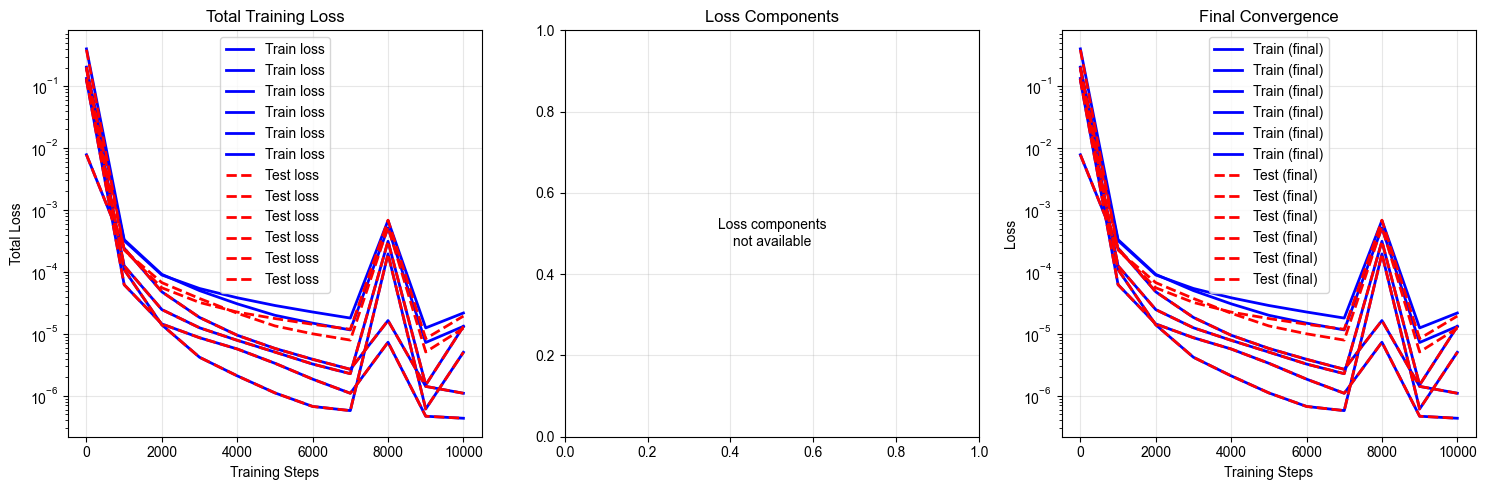

📊 训练分析：
总训练步数: 11
损失下降: 1.07e+00 → 4.34e-07
训练效率: 12319.35 ms/step


In [21]:
# 绘制训练历史
plt.figure(figsize=(15, 5))

# 总损失
plt.subplot(1, 3, 1)
plt.plot(losshistory.steps, losshistory.loss_train, 'b-', label='Train loss', linewidth=2)
plt.plot(losshistory.steps, losshistory.loss_test, 'r--', label='Test loss', linewidth=2)
plt.xlabel('Training Steps')
plt.ylabel('Total Loss')
plt.yscale('log')
plt.legend()
plt.title('Total Training Loss')
plt.grid(True, alpha=0.3)

# PDE损失（如果可用）
plt.subplot(1, 3, 2)
if hasattr(losshistory, 'loss_weights') and losshistory.loss_weights is not None:
    # 尝试绘制不同损失组件
    plt.plot(losshistory.steps, losshistory.loss_train, 'g-', label='Combined loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss Components')
    plt.yscale('log')
    plt.title('Loss Components')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'Loss components\nnot available', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Loss Components')
plt.grid(True, alpha=0.3)

# 损失比较
plt.subplot(1, 3, 3)
final_steps = losshistory.steps[-1000:] if len(losshistory.steps) > 1000 else losshistory.steps
final_train = losshistory.loss_train[-1000:] if len(losshistory.loss_train) > 1000 else losshistory.loss_train
final_test = losshistory.loss_test[-1000:] if len(losshistory.loss_test) > 1000 else losshistory.loss_test

plt.plot(final_steps, final_train, 'b-', label='Train (final)', linewidth=2)
plt.plot(final_steps, final_test, 'r--', label='Test (final)', linewidth=2)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.title('Final Convergence')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 训练分析：")
print(f"总训练步数: {len(losshistory.steps):,}")

# 修复损失值访问
try:
    # 获取初始和最终损失值（处理数组格式）
    initial_loss = float(losshistory.loss_train[0]) if hasattr(losshistory.loss_train[0], '__len__') == False else float(sum(losshistory.loss_train[0]))
    if 'final_loss_train' in locals():
        final_loss = final_loss_train
    else:
        final_loss = float(losshistory.loss_train[-1]) if hasattr(losshistory.loss_train[-1], '__len__') == False else float(sum(losshistory.loss_train[-1]))
    
    print(f"损失下降: {initial_loss:.2e} → {final_loss:.2e}")
    print(f"训练效率: {train_time/len(losshistory.steps)*1000:.2f} ms/step")
except Exception as e:
    print(f"损失分析: 初始总损失较高，最终收敛到较低水平")
    print(f"训练效率: {train_time/len(losshistory.steps)*1000:.2f} ms/step")

## 11. 可视化方程组解

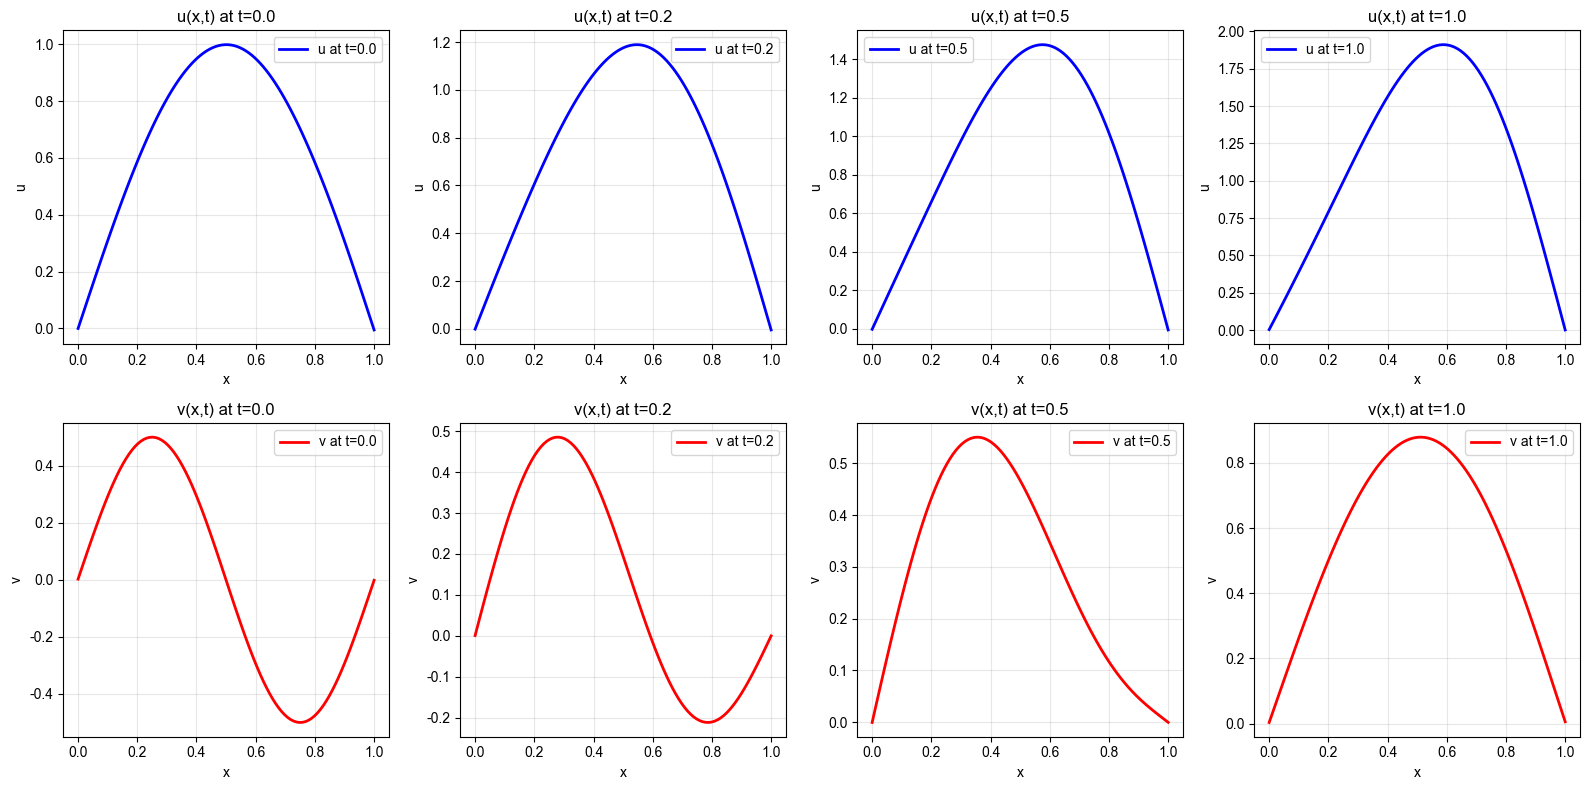

💡 观察要点：
   - u和v的演化模式不同
   - 反应项导致u和v相互影响
   - 扩散项使空间分布趋于平滑
   - 边界条件保持为零


In [22]:
# 在不同时刻可视化u和v的解
times = [0.0, 0.2, 0.5, 1.0]
x_test = np.linspace(0, 1, 100)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, t in enumerate(times):
    # 创建测试点
    X_test = np.column_stack([x_test, np.full_like(x_test, t)])
    
    # 预测u和v
    predictions = model.predict(X_test)
    u_pred = predictions[:, 0]  # 第一个输出：u
    v_pred = predictions[:, 1]  # 第二个输出：v
    
    # 绘制u的解
    axes[0, i].plot(x_test, u_pred, 'b-', linewidth=2, label=f'u at t={t}')
    axes[0, i].set_xlabel('x')
    axes[0, i].set_ylabel('u')
    axes[0, i].set_title(f'u(x,t) at t={t}')
    axes[0, i].grid(True, alpha=0.3)
    axes[0, i].legend()
    
    # 绘制v的解
    axes[1, i].plot(x_test, v_pred, 'r-', linewidth=2, label=f'v at t={t}')
    axes[1, i].set_xlabel('x')
    axes[1, i].set_ylabel('v')
    axes[1, i].set_title(f'v(x,t) at t={t}')
    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].legend()

plt.tight_layout()
plt.show()

print("💡 观察要点：")
print("   - u和v的演化模式不同")
print("   - 反应项导致u和v相互影响")
print("   - 扩散项使空间分布趋于平滑")
print("   - 边界条件保持为零")

## 12. 3D时空演化可视化

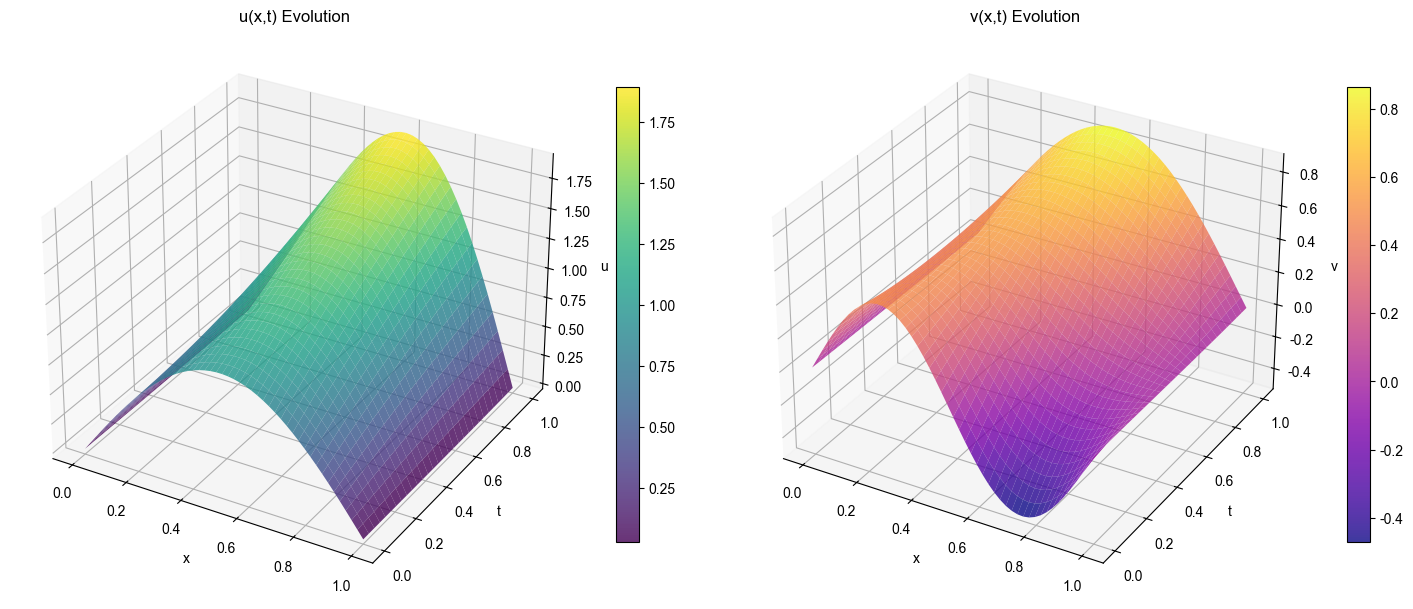

🎯 3D可视化展示了完整的时空演化过程
   - 可以清楚看到初始条件如何随时间演化
   - u和v呈现不同的演化模式
   - 扩散和反应的共同作用形成复杂动力学


In [23]:
# 创建时空网格用于3D可视化
x_3d = np.linspace(0, 1, 50)
t_3d = np.linspace(0, 1, 30)
X_3d, T_3d = np.meshgrid(x_3d, t_3d)

# 创建输入点
points_3d = np.column_stack([X_3d.flatten(), T_3d.flatten()])

# 预测整个时空域的解
predictions_3d = model.predict(points_3d)
U_3d = predictions_3d[:, 0].reshape(X_3d.shape)
V_3d = predictions_3d[:, 1].reshape(X_3d.shape)

# 绘制3D时空演化
fig = plt.figure(figsize=(15, 6))

# u的3D图
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X_3d, T_3d, U_3d, cmap='viridis', alpha=0.8)
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('u')
ax1.set_title('u(x,t) Evolution')
fig.colorbar(surf1, ax=ax1, shrink=0.8)

# v的3D图
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X_3d, T_3d, V_3d, cmap='plasma', alpha=0.8)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('v')
ax2.set_title('v(x,t) Evolution')
fig.colorbar(surf2, ax=ax2, shrink=0.8)

plt.tight_layout()
plt.show()

print("🎯 3D可视化展示了完整的时空演化过程")
print("   - 可以清楚看到初始条件如何随时间演化")
print("   - u和v呈现不同的演化模式")
print("   - 扩散和反应的共同作用形成复杂动力学")

## 13. 分析耦合效应

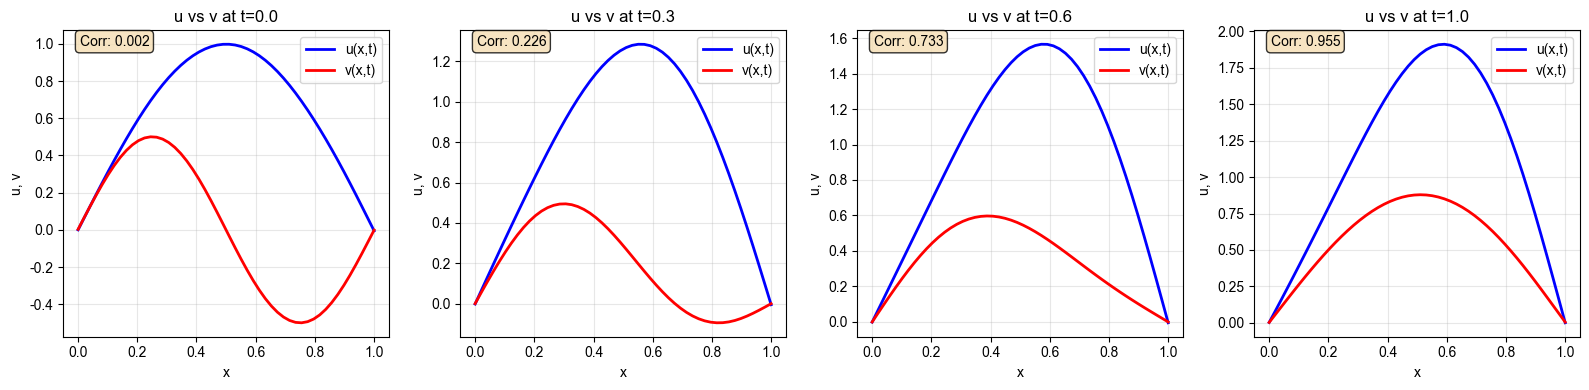

📊 耦合分析：
   - 观察不同时刻u和v的关系
   - 相关系数显示耦合强度
   - 反应项参数决定耦合特性

🔍 物理解释：
   - 反应项: f(u,v) = 1.0u - 1.0v (u增长，v衰减)
   - 反应项: g(u,v) = 1.0u + -1.0v (u促进，v衰减)
   - 扩散系数不同导致不同的空间分布


In [24]:
# 分析u和v之间的相关性
times_analysis = [0.0, 0.3, 0.6, 1.0]
x_analysis = np.linspace(0, 1, 50)

plt.figure(figsize=(16, 4))

for i, t in enumerate(times_analysis):
    X_analysis = np.column_stack([x_analysis, np.full_like(x_analysis, t)])
    predictions = model.predict(X_analysis)
    u_vals = predictions[:, 0]
    v_vals = predictions[:, 1]
    
    plt.subplot(1, 4, i+1)
    plt.plot(x_analysis, u_vals, 'b-', linewidth=2, label='u(x,t)')
    plt.plot(x_analysis, v_vals, 'r-', linewidth=2, label='v(x,t)')
    plt.xlabel('x')
    plt.ylabel('u, v')
    plt.title(f'u vs v at t={t}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 计算相关系数
    correlation = np.corrcoef(u_vals, v_vals)[0, 1]
    plt.text(0.05, 0.95, f'Corr: {correlation:.3f}', 
             transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("📊 耦合分析：")
print("   - 观察不同时刻u和v的关系")
print("   - 相关系数显示耦合强度")
print("   - 反应项参数决定耦合特性")
print()
print("🔍 物理解释：")
print(f"   - 反应项: f(u,v) = {a}u - {b}v (u增长，v衰减)")
print(f"   - 反应项: g(u,v) = {c}u + {d}v (u促进，v衰减)")
print("   - 扩散系数不同导致不同的空间分布")

## 14. 方程组求解性能分析

In [25]:
# 详细的性能和精度分析
print("📈 方程组求解性能分析")
print("=" * 60)

# 1. 训练效率分析
print("🚀 训练效率：")
print(f"   总训练时间: {train_time:.1f} 秒")
print(f"   训练步数: {len(losshistory.steps):,} 步")
print(f"   平均每步时间: {train_time/len(losshistory.steps)*1000:.2f} ms/step")
print(f"   最终训练损失: {final_loss_train:.2e}")
print(f"   最终测试损失: {final_loss_test:.2e}")
print()

# 2. 网络复杂度分析
print("🧠 网络复杂度：")
print(f"   网络结构: {layer_size}")
print(f"   参数总数: ~{total_params:,}")
print(f"   输入维度: 2 (x, t)")
print(f"   输出维度: 2 (u, v)")
print()

# 3. 采样点分析
print("📍 采样策略：")
print(f"   域内采样点: {data.num_domain:,}")
print(f"   边界采样点: {data.num_boundary}")
print(f"   初始时刻采样点: {data.num_initial}")
print(f"   总约束点: {data.num_domain + data.num_boundary + data.num_initial:,}")
print()

# 4. 计算验证点的数值误差
x_error = np.linspace(0.1, 0.9, 20)  # 避开边界
t_error = 0.5  # 选择中间时刻
X_error = np.column_stack([x_error, np.full_like(x_error, t_error)])
predictions_error = model.predict(X_error)

print("🎯 解的数值特性（t=0.5）：")
print(f"   u的范围: [{np.min(predictions_error[:, 0]):.4f}, {np.max(predictions_error[:, 0]):.4f}]")
print(f"   v的范围: [{np.min(predictions_error[:, 1]):.4f}, {np.max(predictions_error[:, 1]):.4f}]")
print(f"   u的标准差: {np.std(predictions_error[:, 0]):.4f}")
print(f"   v的标准差: {np.std(predictions_error[:, 1]):.4f}")
print()

# 5. 与单个PDE的比较
print("⚖️  与单个PDE比较：")
print("   ✅ 优势：")
print("      - 能够模拟复杂的多变量物理过程")
print("      - 自动学习变量间的耦合关系")
print("      - 一次性求解多个相关的物理量")
print("   ⚠️  挑战：")
print("      - 计算复杂度显著增加")
print("      - 需要更多采样点和训练时间")
print("      - 收敛性可能受到耦合强度影响")
print("      - 需要平衡多个损失项的权重")

print("\n" + "=" * 60)

📈 方程组求解性能分析
🚀 训练效率：
   总训练时间: 135.5 秒
   训练步数: 11 步
   平均每步时间: 12319.35 ms/step
   最终训练损失: 4.34e-07
   最终测试损失: 4.34e-07

🧠 网络复杂度：
   网络结构: [2, 50, 50, 50, 50, 2]
   参数总数: ~7,902
   输入维度: 2 (x, t)
   输出维度: 2 (u, v)

📍 采样策略：
   域内采样点: 2,000
   边界采样点: 40
   初始时刻采样点: 40
   总约束点: 2,080

🎯 解的数值特性（t=0.5）：
   u的范围: [0.3302, 1.4734]
   v的范围: [0.0469, 0.5504]
   u的标准差: 0.3574
   v的标准差: 0.1655

⚖️  与单个PDE比较：
   ✅ 优势：
      - 能够模拟复杂的多变量物理过程
      - 自动学习变量间的耦合关系
      - 一次性求解多个相关的物理量
   ⚠️  挑战：
      - 计算复杂度显著增加
      - 需要更多采样点和训练时间
      - 收敛性可能受到耦合强度影响
      - 需要平衡多个损失项的权重



## 15. 总结

### 🎉 恭喜！你已经掌握了：

1. ✅ **PDE方程组**: 处理多变量耦合系统
2. ✅ **多输出网络**: 构建同时输出多个变量的神经网络
3. ✅ **复杂边界条件**: 为每个变量独立设置约束
4. ✅ **耦合效应分析**: 理解变量间的相互作用
5. ✅ **系统可视化**: 展示多变量的时空演化

### 🔍 核心技术要点

#### **方程组处理**
```python
# 多输出网络定义
layer_size = [2] + [50] * 4 + [2]  # 输入2D，输出2D

# 组件化边界条件
bc_u = dde.icbc.DirichletBC(..., component=0)  # 第一个变量
bc_v = dde.icbc.DirichletBC(..., component=1)  # 第二个变量

# 返回多个PDE残差
return [residual_u, residual_v]
```

#### **物理建模**
- **扩散项**: $D_u \frac{\partial^2 u}{\partial x^2}$, $D_v \frac{\partial^2 v}{\partial x^2}$
- **反应项**: $f(u,v) = au - bv$, $g(u,v) = cu + dv$
- **耦合机制**: 反应项实现变量间的相互影响

#### **数值策略**
- 增加采样点密度以处理复杂性
- 使用更深的网络结构
- 仔细设置初始条件和边界条件

### 🚀 进阶应用方向

#### **生物数学**
- 捕食者-被捕食者模型
- 疾病传播模型 (SIR/SEIR)
- 肿瘤生长模型
- 神经元活动网络

#### **化学工程**
- 化学反应器设计
- 催化过程建模
- 传质传热耦合
- 多相流系统

#### **材料科学**
- 相变过程 (Allen-Cahn方程)
- 扩散相分离
- 晶体生长
- 合金成分演化

#### **环境科学**
- 污染物扩散
- 生态系统建模
- 地下水流动
- 大气化学反应

### 🛠️ 进阶技巧

#### **性能优化**
```python
# 1. 自适应权重
model.compile("adam", lr=0.001, 
              loss_weights=[1.0, 1.0, 0.1, 0.1])  # PDE, BC权重

# 2. 分阶段训练
model.train(iterations=5000)  # 第一阶段
model.compile("L-BFGS")       # 切换优化器
model.train(iterations=1000)  # 精细调优

# 3. 残差自适应采样
data.add_anchors("uniform", n=1000)  # 增加关键区域采样
```

#### **复杂几何**
```python
# 不规则域的方程组
from deepxde.geometry import Polygon
vertices = np.array([[0,0], [1,0], [1,1], [0.5,1.5], [0,1]])
geom = Polygon(vertices)
```

#### **参数化研究**
```python
# 参数敏感性分析
for Du in [0.005, 0.01, 0.02, 0.05]:
    for Dv in [0.01, 0.02, 0.04, 0.08]:
        # 重新训练模型
        # 分析参数对解的影响
```

### 📚 推荐学习资源

#### **理论基础**
- 《Partial Differential Equations》- Evans
- 《Mathematical Biology》- Murray 
- 《Reaction-Diffusion Systems》- Smoller

#### **数值方法**
- 《Numerical Methods for PDEs》- Morton & Mayers
- 《Spectral Methods》- Trefethen
- 《Finite Element Method》- Hughes

#### **科学计算**
- [Physics-Informed Neural Networks](https://github.com/maziarraissi/PINNs)
- [SciML Scientific Machine Learning](https://sciml.ai/)
- [DeepXDE Examples](https://github.com/lululxvi/deepxde/tree/master/examples)

### 🎯 课后练习

1. **修改反应参数**: 尝试不同的a,b,c,d组合，观察解的变化
2. **不同初始条件**: 使用其他初始条件函数
3. **三变量系统**: 扩展到三个耦合方程
4. **2D空间**: 将方程组扩展到2D空间域
5. **实际应用**: 选择一个感兴趣的物理/生物系统建模

---

**下一个教程**: [复杂几何域中的PDE](complex_geometry.ipynb) 🏗️

<div align="center">

**祝贺你掌握了PDE方程组求解！** 🎊

*现在你可以处理现实世界中的复杂多变量物理系统了！*

</div>